In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
import os
from datetime import timedelta
from constants import *
from trip_file import TripFile
from matplotlib import pyplot as plt


### Read all files

In [60]:
taarif = pd.read_csv("../files/taarif.csv")
taarif = taarif.drop(0).reset_index().drop(columns=["index"]) # first row is nulls
new_drivers = pd.read_csv("../files/new_drivers.csv", index_col=0)
drivers_with_kviut = pd.read_csv("../files/drivers_with_kviut.csv",index_col=0)

In [61]:
def preprocess_drivers(drivers: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = drivers
    if copy:
        df = drivers.copy()

    gender_mapping = {"F": FEMALE,
                    "M":MALE,
                    "m":MALE,
                    "male":MALE,
                    "boy":MALE,
                    "unknown":UNKOWN,
                    'woman':FEMALE,
                    'girl':FEMALE,
                    'none':UNKOWN,
                    'female':FEMALE,
                    UNKOWN:UNKOWN}

    # Make preprocess
    df.gender = df.gender.fillna(UNKOWN)
    df.gender = df.gender.apply(lambda x: gender_mapping[x])
    df.birthdate = pd.to_datetime(df.birthdate, format="mixed")
    drivers.birthdate = drivers.birthdate.fillna(datetime.datetime.now())

    return df

def preprocess_taarif(taarif_df: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = taarif_df
    if copy:
        df = taarif_df.copy()

    customers_mapping = {
            "dbs" : "yes",
            "mizranei_kfar_saba": "aminach",
            "telecommunication_ltd": "hot" 
    }

    for customer, new_customer in customers_mapping.items():
        # Select the row to duplicate (let's say the first row, index 0)
        row_to_duplicate = df[df["customer"] == customer]
        # Make a copy of the row
        new_row = row_to_duplicate.copy()
        new_row["customer"] = new_customer
        # Append the modified row to the DataFrame
        df = pd.concat([df,pd.DataFrame(new_row)], ignore_index=True)
    
    missing_taarif = ["electricity", "bituch_leumi"]
    
    mean_values = df.drop(columns=["customer"])[df.columns[1:]].mean().values
    df.loc[df["customer"].isin(missing_taarif), df.columns[1:]] = mean_values
    return df
        
# Concat the two tables of drivers with and without kviut
def concat_drivers_tables(new_drivers, drivers_with_kviut):
    drivers_with_kviut["kviut"] = 1
    drivers = pd.concat([new_drivers, drivers_with_kviut])
    drivers["kviut"] = drivers["kviut"].fillna(0)
    return drivers
    

In [62]:
drivers = concat_drivers_tables(new_drivers, drivers_with_kviut)
drivers = preprocess_drivers(drivers, copy=True)
taarif = preprocess_taarif(taarif)

In [63]:
from tqdm import tqdm
def get_trip_files(folder, limit=100):
    files = np.array(list(os.listdir(folder)))
    if limit:
        files = files[:limit]
    files = np.array([name if not name[-5] == ")" else name[:-7]+".csv" for name in files])
    print("Processing files....")
    return np.array([TripFile(os.path.join(folder,file)) for file in tqdm(files)])


def is_friday(time):
    return time.weekday() == 4
def is_after_4pm(time):
    return time.hour >=16
def is_saturday(time):
    return time.weekday() == 5
def is_before_8pm(time):
    return time.hour < 20 or (time.hour == 20 and time.minute == 0 and time.second == 0) 

def is_after_hour(time, hour):
    return time.hour >= hour
def is_before_hour(time, hour):
    return time.hour < hour or (time.hour == hour and time.minute == 0 and time.second == 0) 

def count_time_in_weekend(start_time, end_time):
    count = 0
    current_time = start_time

    while current_time < end_time:
        next_time = min(end_time, current_time + timedelta(hours=1))
        if is_friday(next_time):
            if is_after_hour(next_time, 16):
                friday_4pm = datetime.datetime(next_time.year, next_time.month, next_time.day, 16, 0)
                count += (next_time - max(current_time, friday_4pm)) / timedelta(hours=1)
        elif is_saturday(next_time):
            if is_before_hour(current_time, 20) or is_friday(current_time): # when next time jumps to midnight the current time is still on friday
                saturday_8pm= datetime.datetime(next_time.year, next_time.month, next_time.day, 20, 0)
                count += (min(next_time, saturday_8pm) - current_time) / timedelta(hours=1)
        
        current_time = current_time + timedelta(hours=1)

    return count

def count_drive_weekend_time(start_time, end_time):
    count = 0
    current_time = start_time

    while current_time < end_time:
        next_time = min(end_time, current_time + timedelta(days=1))
        if is_friday(current_time) or is_saturday(current_time):
            if is_friday(current_time):
                weekend_start = datetime.datetime(current_time.year, current_time.month, current_time.day, 22, 0)
                weekend_end = datetime.datetime(current_time.year, current_time.month, current_time.day, 16, 0)
            else:
                weekend_start = datetime.datetime(current_time.year, current_time.month, current_time.day, 22, 0)
                weekend_end = datetime.datetime(current_time.year, current_time.month, current_time.day, 22, 0)
            interval1 = (start_time, end_time)
            # interval2 = (night_start, night_end)
            # count += overlap_hours(interval1, interval2)

    return count



def count_time_at_night(start_time, end_time):
    count = 0
    current_time = start_time

    while current_time < end_time:
        next_time = min(end_time, current_time + timedelta(hours=1))
        if is_after_hour(next_time, 22):
                ten_pm = datetime.datetime(next_time.year, next_time.month, next_time.day, 22, 0)
                count += (next_time - max(current_time, ten_pm)) / timedelta(hours=1)
        elif is_before_hour(current_time, 6) or is_after_hour(current_time, 22):
                six_am = datetime.datetime(next_time.year, next_time.month, next_time.day, 6, 0)
                count += (min(next_time, six_am) - current_time) / timedelta(hours=1)
        
        current_time = current_time + datetime.timedelta(hours=1)
    return count


def count_drive_night_time(start_time, end_time):
    count = 0
    current_time = start_time

    while current_time < end_time:
        next_time = min(end_time, current_time + timedelta(days=1))
        night_start = datetime.datetime(current_time.year, current_time.month, current_time.day, 22, 0)
        night_end = night_start + timedelta(hours=8)
        interval1 = (start_time, end_time)
        interval2 = (night_start, night_end)
        count += overlap_hours(interval1, interval2)

    return count

        

def overlap_hours(interval1, interval2):
    start1, end1 = interval1
    start2, end2 = interval2

    # Check if intervals overlap
    if start1 <= end2 and start2 <= end1:
        # Calculate the overlap duration
        overlap_start = max(start1, start2)
        overlap_end = min(end1, end2)
        overlap_duration = overlap_end - overlap_start

        return overlap_duration.total_seconds() / 3600
    else:
        return 0


def count_time_at_night_and_weekend(start_time, end_time):
    count = 0
    current_time = start_time

    while current_time < end_time:
        next_time = min(end_time, current_time + timedelta(hours=1))
        if is_after_hour(next_time, 22):
            if is_friday(next_time):
                ten_pm = datetime.datetime(next_time.year, next_time.month, next_time.day, 22, 0)
                count += (next_time - max(current_time, ten_pm)) / timedelta(hours=1)
        elif (is_before_hour(current_time, 6) or is_after_hour(current_time, 22)):
            if is_saturday(next_time):
                six_am = datetime.datetime(next_time.year, next_time.month, next_time.day, 6, 0)
                count += (min(next_time, six_am) - current_time) / timedelta(hours=1)
        
        current_time = current_time + timedelta(hours=1)
    return count

# Calculate age function
def calculate_age(birth_date):
    current_date = datetime.datetime.now()
    if pd.isnull(birth_date):
        return np.nan
    age = current_date.year - birth_date.year - ((current_date.month, current_date.day) < (birth_date.month, birth_date.day))
    return age

def create_trips_df(trip_files):
    all_dfs = [trip_file.get_data_frame() for trip_file in trip_files ]
    trips_df = pd.concat(all_dfs)
    trips_df.end_time = pd.to_datetime(trips_df["end_time"])
    trips_df.start_time = pd.to_datetime(trips_df["start_time"])
    trips_df["kph"] = trips_df["km"] / ((trips_df["end_time"] - trips_df["start_time"]) / datetime.timedelta(hours=1))

    trips_df = trips_df.reset_index().drop(columns=["index"])
    trips_df["drive_time"] = (trips_df["end_time"]-trips_df["start_time"]) / timedelta(hours=1)

    sunday_morning = datetime.datetime(2024, 11, 5, 6, 0, 0) # sunday 6 am

    trips_df.loc[(trips_df["start_time"].isna()) & (trips_df["end_time"].isna()),"start_time"] = sunday_morning
    
    return trips_df.drop_duplicates()
    

In [64]:
trip_files = get_trip_files("../files/trips_data", limit=None)


Processing files....


 16%|█▌        | 989/6111 [00:08<00:35, 143.31it/s]c:\Users\Ron Tohar\Desktop\הכשרה\CV_training\basic\python\Basic - Azrieli & Sons data\project_files\trip_file.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trips_df.end_time = pd.to_datetime(trips_df.end_time)
100%|██████████| 6111/6111 [00:56<00:00, 108.85it/s]


In [65]:
from time import time
def calculate_trips_cost(trips_with_fares):
    
    start = time()
    df = trips_with_fares.copy()
    # print("copying time ", time() - start)
    
    start = time()
    
    night_and_weekend_hours =  df.apply(lambda r: count_time_at_night_and_weekend(r.start_time, r.end_time), axis=1)
    # print("calculate night and weekend time ", time() - start)
    start = time()

    weekend_hours = df.apply(lambda r: count_time_in_weekend(r.start_time, r.end_time), axis=1) - night_and_weekend_hours
    # print("calculate weekend time ", time() - start)
    start = time()

    # night_hours2 = df.apply(lambda r: count_drive_night_time(r.start_time, r.end_time), axis=1) - night_and_weekend_hours
    night_hours = df.apply(lambda r: count_time_at_night(r.start_time, r.end_time), axis=1) - night_and_weekend_hours
    # print("calculate night time ", time() - start)


    start = time()
    km_per_hour = df["km"] / ((df["end_time"]-df["start_time"]) / timedelta(hours=1))
    # print("calculate kph ", time() - start)
    
    start = time()
    basic_pay = df.km * df.basic_taarif
    extra_pay = df.km.apply(lambda km: max(0, km - 200)) * df.extra_milage
    payment_without_bonus = basic_pay + extra_pay
    payment_per_km = payment_without_bonus / df["km"]
    # print("calculate basic payments ", time() - start)


    start = time()
    # bonus_precentage = ((weekend_hours * df.weekend_bonus) + (night_hours * df.night_bonus) + (night_and_weekend_hours * (df.weekend_bonus + df.night_bonus)))
    night_extra_payment = (df.night_bonus / 100) * ((km_per_hour * night_hours) * payment_per_km)
    weekend_extra_payment = (df.weekend_bonus / 100) * ((km_per_hour * weekend_hours) * payment_per_km)
    night_and_weekend_extra_payment = ((df.weekend_bonus + df.night_bonus) / 100) * ((km_per_hour * night_and_weekend_hours) * payment_per_km)
    payment_with_bonus = payment_without_bonus + night_extra_payment + weekend_extra_payment + night_and_weekend_extra_payment
    # print("calculate bonuses ", time() - start)

    df["basic_pay"] = basic_pay
    df["extra_milage_pay"] = extra_pay
    df["weekend_hours"] = weekend_hours
    df["night_hours"] = night_hours
    df["night_and_weekend_hours"] = night_and_weekend_hours
    df["kph"] = km_per_hour
    df["weekend_km"] = weekend_hours * km_per_hour
    df["night_extra_payment"] = night_extra_payment
    df["weekend_extra_payment"] = weekend_extra_payment
    df["night_and_weekend_extra_payment"] = night_and_weekend_extra_payment
    df["bonus_payment"] = night_extra_payment + weekend_extra_payment + night_and_weekend_extra_payment
    df["payment_without_bonus"] = payment_without_bonus
    df["payment_with_bonus"] = payment_with_bonus
    
    return df


def create_main_table(trips_df):
    cum_table = pd.DataFrame(columns=["driver_id","month","year","total_income","total_km"])
    print("Processing income of drivers...")

    trips_with_fares = pd.merge(trips_df, taarif, on=["customer"],how="left")
    df = calculate_trips_cost(trips_with_fares)
    df["num_drives"] = 1 # to count number of trips
    df["total_time"] = (df["end_time"] - df["start_time"]) / timedelta(hours=1)

    subset_columns = ["driver_id", "month", "year", "payment_with_bonus", "km", "num_drives","total_time"]
    df_to_concat = df[subset_columns]
    new_column_names = {'payment_with_bonus': 'total_income', 'km': 'total_km'}
    df_to_concat = df_to_concat.rename(columns=new_column_names)
    
    # cum_table = pd.concat([cum_table, df_to_concat], axis=0, join="outer")
    # cum_table = cum_table.reset_index().drop(columns=["index"])
    cum_table = df_to_concat
    cum_table = cum_table.groupby(["driver_id","month","year"]).sum().reset_index()

    drivers_copy = drivers.copy()
    drivers_copy["age"] = drivers.birthdate.apply(calculate_age)
    drivers_copy = drivers_copy.rename(columns={"id":"driver_id"})
        
    cum_table = pd.merge(cum_table, drivers_copy[["driver_id","gender","age","vetek","kviut"]], on=["driver_id"], how="left")
    cum_table["average_km"] = cum_table["total_km"] / cum_table["num_drives"]
    return cum_table

# table = create_main_table(trip_files, trips_df)

In [66]:
trips_df = create_trips_df(trip_files)

### Train model to predict missing times

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_data_start_time(df1):
    df = df1.copy()
    df["drive_time"] = (df["end_time"]-df["start_time"]) / timedelta(hours=1)
    df["day_of_week"] = df["start_time"].dt.day.astype("category")
    df["is_weekend"] = df["day_of_week"].apply(lambda x: x==5 or x==6)
    df["hour"] = df["start_time"].dt.hour
    df["minute"] = df["start_time"].dt.minute
    return df[['day_of_week', 'hour', "minute","is_weekend", "km","kph"]]

def preprocess_data_end_time(df1):
    df = df1.copy()
    df["drive_time"] = (df["end_time"]-df["start_time"]) / timedelta(hours=1)
    df["day_of_week"] = df["end_time"].dt.day.astype("category")
    df["is_weekend"] = df["day_of_week"].apply(lambda x: x==5 or x==6)
    df["hour"] = df["end_time"].dt.hour
    df["minute"] = df["end_time"].dt.minute
    return df[['day_of_week', 'hour', "minute","is_weekend", "km","kph"]]

def train_model_start_time(trips_df):
    
    model = Pipeline([
        ("standard scaler", StandardScaler()),
        ('model', LinearRegression())  # Example model, replace with your own
    ])

    trips_with_times = trips_df[(~trips_df["start_time"].isna()) & (~trips_df["end_time"].isna())]

    data = preprocess_data_start_time(trips_with_times)
    X_train,y_train = data.drop(columns=["kph"]), data["kph"].values
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    return model

def train_model_end_time(trips_df):
    
    model = Pipeline([
        ("standard scaler", StandardScaler()),
        ('model', LinearRegression())  # Example model, replace with your own
    ])

    trips_with_times = trips_df[(~trips_df["start_time"].isna()) & (~trips_df["end_time"].isna())]

    data = preprocess_data_end_time(trips_with_times)
    X_train, y_train = data.drop(columns=["kph"]), data["kph"].values
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    return model

In [68]:

# calculate time by km went and kph prediction
def get_slow_outliers_fixed(trips_df, model):
    outliers_slow = trips_df[(trips_df["drive_time"] >30) & ((trips_df["kph"] < 50)) ]
    outliers_slow_kph = model.predict(preprocess_data_start_time(outliers_slow).drop(columns="kph"))
    
    outliers_slow_fixed_drive_time = outliers_slow["km"] / outliers_slow_kph
    outliers_slow["fixed_drive_time"] = outliers_slow_fixed_drive_time
    outliers_slow["predicted_kph"] = outliers_slow_kph
    return outliers_slow

# get avg km of driver and calculate drive time by it
def get_fast_outliers_fixed(trips_df, model):
    outliers = trips_df[((trips_df["drive_time"] >30) & ((trips_df["kph"] > 150))) | (trips_df["km"] > 4000)]
    # outliers = outliers[(outliers["km"] > 4000)]

    drivers_avg_km_df = trips_df[trips_df.driver_id.isin(outliers.driver_id.unique())][["driver_id", "km"]].groupby("driver_id").mean()
    drivers_avg_km_df = drivers_avg_km_df.rename(columns = {"km": "avg_km"})
    outliers = outliers.merge(drivers_avg_km_df, on=["driver_id"])

    outliers_kph = model.predict(preprocess_data_start_time(outliers).drop(columns="kph"))
    outliers_fixed_drive_time = outliers["avg_km"] / outliers_kph
    outliers["fixed_drive_time"] = outliers_fixed_drive_time
    outliers["predicted_kph"] = outliers_kph
    return outliers

def get_outliers_fixed(trips_df, model, outliers_list):
    # get outliers with fixed_drive_time and predicted_kph
    
    # slow_outliers = get_slow_outliers_fixed(trips_df, model)
    # fast_outliers = get_fast_outliers_fixed(trips_df,model)
    # outliers_fixed = pd.concat([slow_outliers,fast_outliers])
    outliers_fixed = pd.concat(outliers_list)
 
    df = pd.merge(trips_df, outliers_fixed[["driver_id", "customer","start_time","end_time","month","year","fixed_drive_time","predicted_kph"]], on=["driver_id", "customer","start_time","end_time","month","year"], how="left") 
    df.loc[~df["fixed_drive_time"].isna(), "end_time"] = df[~df["fixed_drive_time"].isna()]["start_time"] + df[~df["fixed_drive_time"].isna()]["fixed_drive_time"].apply(lambda x: timedelta(hours=x)) # fix end time according to predicted drive time and start time
    df.loc[~df["fixed_drive_time"].isna(), "km"] = df.loc[~df["fixed_drive_time"].isna(), "fixed_drive_time"]  * df.loc[~df["fixed_drive_time"].isna(), "predicted_kph"] 
    return df

def get_final_outliers_fixed(trips_df, outliers, model):
    drivers_avg_km_df = trips_df[trips_df.driver_id.isin(outliers.driver_id.unique())][["driver_id", "km"]].groupby("driver_id").mean()
    drivers_avg_km_df = drivers_avg_km_df.rename(columns = {"km": "avg_km"})
    outliers = outliers.merge(drivers_avg_km_df, on=["driver_id"])
    outliers_kph = model.predict(preprocess_data_start_time(outliers).drop(columns="kph"))
    outliers_fixed_drive_time = outliers["avg_km"] / outliers_kph
    outliers["fixed_drive_time"] = outliers_fixed_drive_time
    outliers["predicted_kph"] = outliers_kph
    return outliers



In [69]:
def get_missing_start_time_fixed(trips_df, model):
    df = trips_df.copy()
    
    data = df[df["start_time"].isna()] # all rows without start time
    predicted_kph = model.predict(preprocess_data_end_time(data).drop(columns="kph"))
    fixed_drive_time = data["km"]/predicted_kph
    fixed_drive_timedelta = fixed_drive_time.apply(lambda x: timedelta(hours=x))
    df.loc[df["start_time"].isna(), "start_time"] = df.loc[df["start_time"].isna(), "end_time"] - fixed_drive_timedelta
    return df

def get_missing_end_time_fixed(trips_df, model):
    df = trips_df.copy()

    data = df[df["end_time"].isna()] # all rows without end time
    predicted_kph = model.predict(preprocess_data_start_time(data).drop(columns="kph"))
    fixed_drive_time = data["km"]/predicted_kph
    fixed_drive_timedelta = fixed_drive_time.apply(lambda x: timedelta(hours=x))
    df.loc[df["end_time"].isna(), "end_time"] = df.loc[df["end_time"].isna(), "start_time"] + fixed_drive_timedelta
    return df




In [70]:
def split_outliers(df):
    df = trips_df
    z_scores = (df['km'] - df['km'].mean()) / df['km'].std()
    threshold = 1.5
    return df[abs(z_scores) <= threshold], df[abs(z_scores) > threshold]

In [71]:

# trips_df = create_trips_df(trip_files)
# # no_outliers = trips_df[(~(((trips_df["drive_time"] >30) & ((trips_df["kph"] < 50))) | ((trips_df["drive_time"] >30) & ((trips_df["kph"] > 150))) ))]
# # no_outliers = no_outliers[(no_outliers["km"] < 4000)]
# no_outliers, outliers = split_outliers(trips_df)

# model_end_time_predictions = train_model_start_time(no_outliers)
# model_start_time_predictions = train_model_end_time(no_outliers) 

# trips_df = get_outliers_fixed(trips_df, model_start_time_predictions)

# trips_df = get_missing_start_time_fixed(trips_df, model=model_start_time_predictions)
# trips_df = get_missing_end_time_fixed(trips_df, model=model_end_time_predictions)


In [72]:

trips_df = create_trips_df(trip_files)
# no_outliers = trips_df[(~(((trips_df["drive_time"] >30) & ((trips_df["kph"] < 50))) | ((trips_df["drive_time"] >30) & ((trips_df["kph"] > 150))) ))]
# no_outliers = no_outliers[(no_outliers["km"] < 4000)]
no_outliers, outliers = split_outliers(trips_df)

model_end_time_predictions = train_model_start_time(no_outliers)
model_start_time_predictions = train_model_end_time(no_outliers) 

slow_outliers = get_slow_outliers_fixed(trips_df, model_start_time_predictions)
fast_outliers = get_fast_outliers_fixed(trips_df,model_start_time_predictions)
outliers_list = [slow_outliers, fast_outliers]

trips_df = get_outliers_fixed(trips_df,model_start_time_predictions, outliers_list, )

trips_df = get_missing_start_time_fixed(trips_df, model=model_start_time_predictions)
trips_df = get_missing_end_time_fixed(trips_df, model=model_end_time_predictions)


C:\Users\Ron Tohar\AppData\Local\Temp\ipykernel_14256\926679890.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_slow["fixed_drive_time"] = outliers_slow_fixed_drive_time
C:\Users\Ron Tohar\AppData\Local\Temp\ipykernel_14256\926679890.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_slow["predicted_kph"] = outliers_slow_kph


In [73]:
table = create_main_table(trips_df.drop_duplicates())


Processing income of drivers...


Text(0.5, 1.0, 'Monthly incomes')

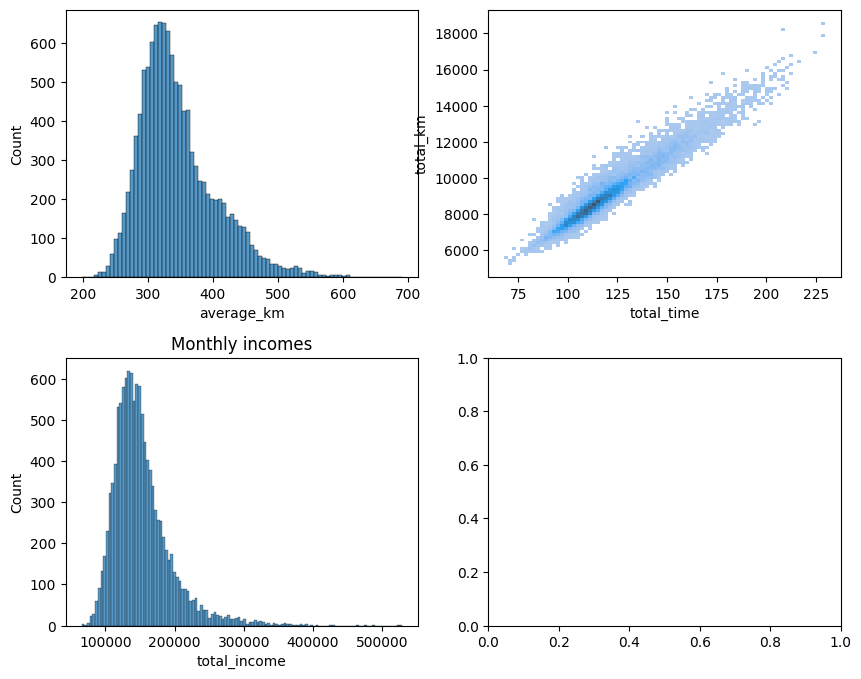

In [74]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 1 column
fig.subplots_adjust(hspace=0.3)
sns.histplot(data=table,x="average_km", ax=axes[0,0])
sns.histplot(data=table,y="total_km",x="total_time",ax=axes[0,1])
sns.histplot(x="total_income", data=table, ax=axes[1,0]).set_title("Monthly incomes")

In [75]:
table[table["total_income"] > 400_000]


,driver_id,month,year,total_income,total_km,num_drives,total_time,gender,age,vetek,kviut,average_km
424,36,january,2015,486186.273513,14950.984888,26,204.366667,m,35.0,16.3,1.0,575.037880
1843,154,march,2015,528632.708909,16563.974213,27,207.883333,m,124.0,6.9,1.0,613.480526
1958,164,december,2015,424647.689728,14823.967146,27,184.250000,m,38.0,10.5,1.0,549.035820
2928,245,april,2015,404782.454829,13246.635541,27,171.930438,m,59.0,13.2,1.0,490.616131
4335,362,february,2015,407715.058390,17902.250378,27,229.126543,m,37.0,3.7,1.0,663.046310
5800,484,january,2015,522590.812068,15518.464417,27,193.666667,m,34.0,4.1,1.0,574.757941
5903,492,september,2015,474983.263603,15612.087006,27,198.983333,m,45.0,11.8,1.0,578.225445
7422,619,june,2015,464674.405012,13498.313982,26,177.290664,m,53.0,4.2,1.0,519.165922
11562,964,june,2015,429902.371361,15014.143752,27,200.285497,m,48.0,6.4,1.0,556.079398


In [76]:
trips_df[(trips_df['driver_id'] == 818) & (trips_df['month'] == "october")]

,customer,driver_id,end_time,km,start_time,month,year,kph,drive_time,fixed_drive_time,predicted_kph
265606,hot,818,2015-10-20 17:38:00,246.058274,2015-10-20 13:32:00,october,2015,60.014213,4.100000,NaN,NaN
266498,aminach,818,2015-10-07 19:32:00,304.034378,2015-10-07 15:29:00,october,2015,75.070217,4.050000,NaN,NaN
266998,bituch_leumi,818,2015-10-14 16:46:00,310.816682,2015-10-14 13:06:00,october,2015,84.768186,3.666667,NaN,NaN
267168,aminach,818,2015-10-18 19:53:00,464.375621,2015-10-18 12:34:00,october,2015,63.468194,7.316667,NaN,NaN
268497,electricity,818,2015-10-17 18:13:00,3456.707042,2015-10-16 03:07:00,october,2015,88.406830,39.100000,NaN,NaN
269404,electricity,818,2015-10-03 18:28:00,208.689276,2015-10-03 15:50:00,october,2015,79.249092,2.633333,NaN,NaN
269656,bituch_leumi,818,2015-10-21 17:40:00,318.894793,2015-10-21 13:38:00,october,2015,79.064825,4.033333,NaN,NaN
270112,iaf,818,2015-10-06 17:24:00,289.754439,2015-10-06 13:28:00,october,2015,73.666383,3.933333,NaN,NaN
270809,bituch_leumi,818,2015-10-04 05:03:00,402.235371,2015-10-04 00:01:00,october,2015,79.914312,5.033333,NaN,NaN
271821,jerusalem_muni,818,2015-10-24 09:54:00,442.614775,2015-10-24 03:28:00,october,2015,68.800224,6.433333,NaN,NaN


In [77]:
table.to_csv("../payments.csv")